# Use Case 9: Luke’s Genealogy Passage Entropy Hotspot (N1904addons)¶

## Table of content (ToC)<a class="anchor" id="TOC"></a>
* <a href="#bullet1">1 - Introduction</a>
* <a href="#bullet2">2 - Load TF with the N1904addons</a>
* <a href="#bullet3">3 - Analysis</a>
    * <a href="#bullet3x1">3.1 - Stand alone examples</a>
    * <a href="#bullet3x2">3.2 - Actual entropy distribution</a>
    * <a href="#bullet3x3">3.3 - Locate entropy hotspots</a>
    * <a href="#bullet3x4">3.4 - Initial observations</a>
    * <a href="#bullet3x5">3.5 - Creating a more detailed script</a>
    * <a href="#bullet3x6">3.6 - Include only verses with a minimum morph diversity</a>
* <a href="#bullet4">4 - Examine phrase function probability mapping</a>
* <a href="#bullet5">5 - Attribution and footnotes</a>
* <a href="#bullet6">6 - Required libraries</a>
* <a href="#bullet7">7 - Notebook version</a>


#  1 - Introduction <a class="anchor" id="bullet1"></a>
##### [Back to ToC](#TOC)

This Jupyter Notebook demonstrates the use of one of the entropy features included in the N1904addons.

All entropy related features in the N1904addons dataset can be viewed <a href="https://tonyjurg.github.io/N1904addons/features/#feature-group-statistic" target="_blank">here</a>. 

This notebook will use the feature <a href="https://tonyjurg.github.io/N1904addons/features/morph_entr_mbit.html" target="_blank">`morph_entr_norm`</a>. In practical terms, this feature reflects how predictable a morphs syntactic behavior is predictable. Thus how consistently a given morph (as stored in the <a href="https://centerblc.github.io/N1904/features/morph.html" target="_blank">`morph`</a> feature) maps to a particular phrase function.

# 2 -  Load TF with the N1904addons <a class="anchor" id="bullet2"></a>
##### [Back to ToC](#TOC)

In [1]:
# Loading the Text-Fabric code
from tf.fabric import Fabric
from tf.app import use

In [2]:
# Load the N1904-TF app and data with the additional features
A = use ("CenterBLC/N1904", version="1.0.0", mod="tonyjurg/N1904addons/tf/", hoist=globals())

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,27,5102.93,100
chapter,260,529.92,100
verse,7944,17.34,100
sentence,8011,17.20,100
group,8945,7.01,46
clause,42506,8.36,258
wg,106868,6.88,533
phrase,69007,1.90,95
subphrase,116178,1.60,135
word,137779,1.00,100


Display is setup for viewtype [syntax-view](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/syntax-view.md#start)

See [here](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/viewtypes.md#start) for more information on viewtypes

# 3 - Analysis <a class="anchor" id="bullet3"></a>
##### [Back to ToC](#TOC)

## 3.1 - Stand alone examples <a class="anchor" id="bullet3x1"></a>

The following codeblock generates a plot with entropy values for a set of example distributions. By using round numbers, the plot provides insight in how to interpret entropy values.

For simplicity, the model below assumes eight possible outcomes, resulting in a maximum entropy of 3 since log2(8)=3. When one outcome dominates (as in a heavily skewed distribution defined below), entropy approaches zero, reflecting high predictability. An entropy of zero signifies complete certainty. Conversely, a perfectly even distribution across all eight outcomes produces the maximum entropy of 3, indicating maximum uncertainty.

The `compute_entropy()` function implements the standard Shannon entropy formula. The Shannon entropy $ H $ of a discrete probability distribution is defined as:

$$H = -\sum_{i=1}^{n} p_i \log_2 p_i$$


where $ p_i $ is the probability of outcome $ i $, and the sum is taken over all possible outcomes.

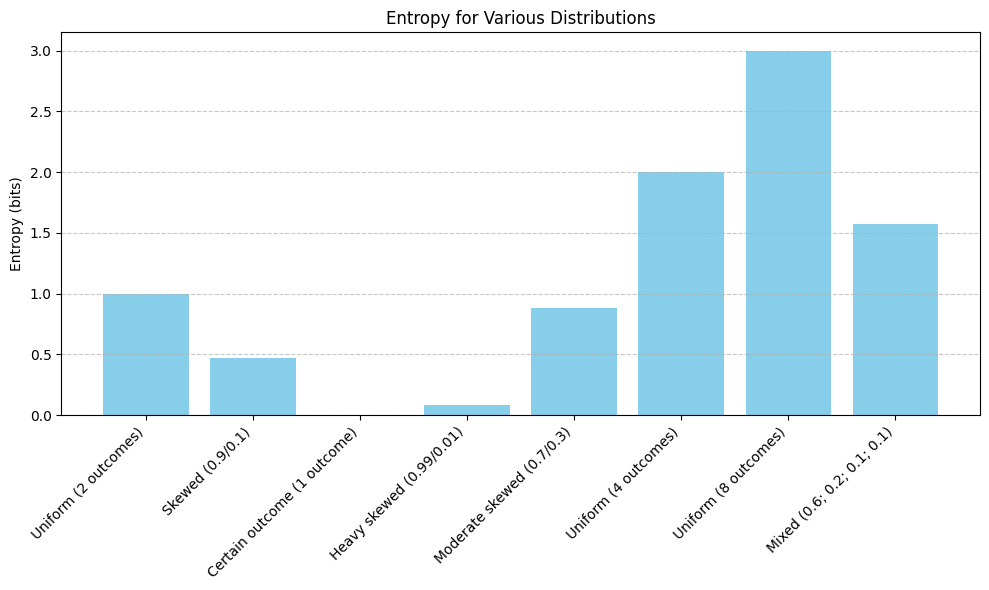

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define entropy function
def compute_entropy(prob_dist):
    return -sum(p * np.log2(p) for p in prob_dist if p > 0)

# Example distributions
distributions = {
    "Uniform (2 outcomes)": [0.5, 0.5],
    "Skewed (0.9/0.1)": [0.9, 0.1],
    "Certain outcome (1 outcome)": [1],
    "Heavy skewed (0.99/0.01)": [0.99, 0.01],
    "Moderate skewed (0.7/0.3)": [0.7, 0.3],
    "Uniform (4 outcomes)": [0.25, 0.25, 0.25, 0.25],
    "Uniform (8 outcomes)": [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125] ,
    "Mixed (0.6; 0.2; 0.1; 0.1)": [0.6, 0.2, 0.1, 0.1],
}

# Compute entropy values
entropy_values = [compute_entropy(p) for p in distributions.values()]

# Plot entropy for predefined distributions
plt.figure(figsize=(10, 6))
plt.bar(distributions.keys(), entropy_values, color='skyblue')
plt.ylabel('Entropy (bits)')
plt.xticks(rotation=45, ha='right')
plt.title('Entropy for Various Distributions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 3.2 - Actual entropy distribution <a class="anchor" id="bullet3x2"></a>

Now let us look at the actual entropy distribution in the N1904-TF dataset for feature <a href="https://tonyjurg.github.io/N1904addons/features/morph_entr_norm.html" taget="_blank">`morph_entr_norm`</a>.

<img src="https://raw.githubusercontent.com/tonyjurg/N1904addons/main/docs/features/images/entropy_distribution_morph.png" width=600>

## 3.3 - Locate entropy hotspots <a class="anchor" id="bullet3x3"></a>

The following script scans the entire N1904-TF dataset verse by verse to pinpoint “hotspots” of morphological uncertainty. For each verse it gathers all word nodes, filters out those lacking a normalized entropy value (should not happen), and then computes the verse’s average entropy and locates the single word with the highest entropy. It also records the verse’s token count and retrieves its full original Greek text.  

All of these metrics (mean entropy, hottest word and its entropy, verse length, and text) are stored. The verses are then sorted by descending mean entropy. This means that the top ten most morphologically ambiguous passages can be displayed with precise book-chapter-verse references, token counts, etc.

In [3]:
hotspots = []

# Loop over every verse node in the Text-Fabric corpus
for verse in F.otype.s('verse'):
    # Retrieve all word nodes within this verse
    words = L.d(verse, otype='word')

    # Build a list of (word_node, entropy_value) pairs,
    # converting back to the true float by dividing by 1000
    pairs = [
        (w, float(F.morph_entr_norm.v(w)) / 1000.0)
        for w in words
        if F.morph_entr_norm.v(w)  # only include words with an entropy value
    ]
    # If no words in this verse have entropy, skip to the next verse
    if not pairs:
        continue

    # (a) Compute the average entropy across ALL words in the verse
    mean_ent = sum(ent for _, ent in pairs) / len(words)

    # (b) Identify the single word with the maximum entropy value
    max_w, max_val = max(pairs, key=lambda p: p[1])

    # (c) Record the total number of tokens (verse length)
    length = len(words)

    # (d) Extract the full original Greek text of the verse for display
    verse_txt = T.text(verse, fmt="text-orig-full").strip()

    # Append a tuple of metrics for later ranking:
    #   (average_entropy, verse_node, hottest_word_node, max_entropy, verse_length, verse_text)
    hotspots.append((mean_ent, verse, max_w, max_val, length, verse_txt))

# -----------------------------------------------------------------------------
# Sort all verses by descending average entropy and display the top 10 "hotspots"
# -----------------------------------------------------------------------------
for mean_ent, verse, max_w, max_val, length, verse_txt in \
        sorted(hotspots, key=lambda x: x[0], reverse=True)[:10]:
    # Determine book, chapter, and verse number from the word node location
    book, chapter, verse_no = T.sectionFromNode(max_w)

    # Print a summary line including:
    #   - reference (book chapter:verse)
    #   - mean entropy
    #   - verse length (# tokens)
    #   - hottest word, its primary morph tag, and its entropy value
    print(
        f"{book} {chapter}:{verse_no}  "
        f"mean={mean_ent:.4f}  "
        f"len={length:3}  "
        f"max={F.text.v(max_w)} {F.morph.v(max_w)} ({max_val:.4f})"
    )
    # Print the full verse text
    print("   ", verse_txt)
    # Separator line
    print("-" * 100)


Luke 3:24  mean=0.6120  len= 10  max=Ματθὰτ N-PRI (0.6590)
    τοῦ Ματθὰτ τοῦ Λευεὶ τοῦ Μελχεὶ τοῦ Ἰανναὶ τοῦ Ἰωσὴφ
----------------------------------------------------------------------------------------------------
Luke 3:27  mean=0.6120  len= 10  max=Ἰωανὰν N-PRI (0.6590)
    τοῦ Ἰωανὰν τοῦ Ῥησὰ τοῦ Ζοροβάβελ τοῦ Σαλαθιὴλ τοῦ Νηρεὶ
----------------------------------------------------------------------------------------------------
Luke 3:28  mean=0.6120  len= 10  max=Μελχεὶ N-PRI (0.6590)
    τοῦ Μελχεὶ τοῦ Ἀδδεὶ τοῦ Κωσὰμ τοῦ Ἐλμαδὰμ τοῦ Ἢρ
----------------------------------------------------------------------------------------------------
Luke 3:31  mean=0.6120  len= 10  max=Μελεὰ N-PRI (0.6590)
    τοῦ Μελεὰ τοῦ Μεννὰ τοῦ Ματταθὰ τοῦ Ναθὰμ τοῦ Δαυεὶδ
----------------------------------------------------------------------------------------------------
Luke 3:32  mean=0.6120  len= 10  max=Ἰεσσαὶ N-PRI (0.6590)
    τοῦ Ἰεσσαὶ τοῦ Ἰωβὴδ τοῦ Βοὸς τοῦ Σαλὰ τοῦ Ναασσὼν
------------------

## 3.4 - Initial observations <a class="anchor" id="bullet3x4"></a>

Notably, all ten verses are drawn from Luke’s genealogy passage (Luke 3:23–38) which consists of a highly repetitive sequence of ancestral names structured as appositional genitive chains:

```
τοῦ <Name1> τοῦ <Name2> τοῦ <Name3> …
```

literally, “of <Name1>, of <Name2>, …,” a compact way of saying “the son of <Name1>, the son of <Name2>,” and so on. In this case, a passage that is structurally straightforward and contextually unambiguous nonetheless exhibits maximal statistical ambiguity, as captured by the entropy metric. 

## 3.5 - Creating a more detailed script <a class="anchor" id="bullet3x5"></a>

This calls for a better script that will print in a nice table format the Greek text aligned with the morph tag and the entropy value underneat it.

In [4]:
import pandas as pd
from IPython.display import display

# 1. Collect verse-level entropy metrics
hotspots = []
for verse_node in F.otype.s('verse'):
    # (a) Retrieve all word nodes within the current verse
    words = L.d(verse_node, otype='word')

    # (b) Build (word_node, entropy_value) pairs, scaling back by 1000
    pairs = [
        (w, float(F.morph_entr_norm.v(w)) / 1000.0)
        for w in words
        if F.morph_entr_norm.v(w)
    ]
    if not pairs:
        continue

    # (c) Compute mean entropy over the full verse token count
    mean_ent = sum(ent for _, ent in pairs) / len(words)

    # (d) Find the word with the maximum entropy
    max_w, max_val = max(pairs, key=lambda p: p[1])

    # (e) Record verse length and text
    length = len(words)
    verse_text = T.text(verse_node, fmt="text-orig-full").strip()

    # (f) Store metrics for ranking
    hotspots.append((mean_ent, verse_node, max_w, max_val, length, verse_text))

# 2. Sort and pick top 10
hotspots_sorted = sorted(hotspots, key=lambda x: x[0], reverse=True)
top10 = hotspots_sorted[:10]

# 3. Display results
for mean_ent, verse_node, max_w, max_val, length, verse_text in top10:
    book, chapter, verse_no = T.sectionFromNode(verse_node)
    print(f">>> {book} {chapter}:{verse_no}  mean_entropy={mean_ent:.4f}  length={length}")
    print("   ", verse_text)
    
    # Re-fetch the words for this verse_node
    words = L.d(verse_node, otype='word')

    # Build aligned rows: surface form, morph tag, and scaled entropy
    headers = [F.text.v(w) for w in words]
    morphs  = [F.morph.v(w) or '' for w in words]
    ents    = [
        f"{float(F.morph_entr_norm.v(w)) / 1000.0:.4f}" if F.morph_entr_norm.v(w) else ''
        for w in words
    ]

    df = pd.DataFrame(
        data=[morphs, ents],
        index=['morph', 'entropy'],
        columns=headers
    )
    display(df)
    print('-' * 80)

>>> Luke 3:24  mean_entropy=0.6120  length=10
    τοῦ Ματθὰτ τοῦ Λευεὶ τοῦ Μελχεὶ τοῦ Ἰανναὶ τοῦ Ἰωσὴφ


,τοῦ,Ματθὰτ,τοῦ,Λευεὶ,τοῦ,Μελχεὶ,τοῦ,Ἰανναὶ,τοῦ,Ἰωσὴφ
morph,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI
entropy,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590


--------------------------------------------------------------------------------
>>> Luke 3:27  mean_entropy=0.6120  length=10
    τοῦ Ἰωανὰν τοῦ Ῥησὰ τοῦ Ζοροβάβελ τοῦ Σαλαθιὴλ τοῦ Νηρεὶ


,τοῦ,Ἰωανὰν,τοῦ,Ῥησὰ,τοῦ,Ζοροβάβελ,τοῦ,Σαλαθιὴλ,τοῦ,Νηρεὶ
morph,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI
entropy,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590


--------------------------------------------------------------------------------
>>> Luke 3:28  mean_entropy=0.6120  length=10
    τοῦ Μελχεὶ τοῦ Ἀδδεὶ τοῦ Κωσὰμ τοῦ Ἐλμαδὰμ τοῦ Ἢρ


,τοῦ,Μελχεὶ,τοῦ,Ἀδδεὶ,τοῦ,Κωσὰμ,τοῦ,Ἐλμαδὰμ,τοῦ,Ἢρ
morph,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI
entropy,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590


--------------------------------------------------------------------------------
>>> Luke 3:31  mean_entropy=0.6120  length=10
    τοῦ Μελεὰ τοῦ Μεννὰ τοῦ Ματταθὰ τοῦ Ναθὰμ τοῦ Δαυεὶδ


,τοῦ,Μελεὰ,τοῦ,Μεννὰ,τοῦ,Ματταθὰ,τοῦ,Ναθὰμ,τοῦ,Δαυεὶδ
morph,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI
entropy,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590


--------------------------------------------------------------------------------
>>> Luke 3:32  mean_entropy=0.6120  length=10
    τοῦ Ἰεσσαὶ τοῦ Ἰωβὴδ τοῦ Βοὸς τοῦ Σαλὰ τοῦ Ναασσὼν


,τοῦ,Ἰεσσαὶ,τοῦ,Ἰωβὴδ,τοῦ,Βοὸς,τοῦ,Σαλὰ,τοῦ,Ναασσὼν
morph,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI
entropy,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590


--------------------------------------------------------------------------------
>>> Luke 3:34  mean_entropy=0.6120  length=10
    τοῦ Ἰακὼβ τοῦ Ἰσαὰκ τοῦ Ἀβραὰμ τοῦ Θάρα τοῦ Ναχὼρ


,τοῦ,Ἰακὼβ,τοῦ,Ἰσαὰκ,τοῦ,Ἀβραὰμ,τοῦ,Θάρα,τοῦ,Ναχὼρ
morph,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI
entropy,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590


--------------------------------------------------------------------------------
>>> Luke 3:35  mean_entropy=0.6120  length=10
    τοῦ Σεροὺχ τοῦ Ῥαγαῦ τοῦ Φάλεκ τοῦ Ἔβερ τοῦ Σαλὰ


,τοῦ,Σεροὺχ,τοῦ,Ῥαγαῦ,τοῦ,Φάλεκ,τοῦ,Ἔβερ,τοῦ,Σαλὰ
morph,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI
entropy,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590


--------------------------------------------------------------------------------
>>> Luke 3:36  mean_entropy=0.6120  length=10
    τοῦ Καϊνὰμ τοῦ Ἀρφαξὰδ τοῦ Σὴμ τοῦ Νῶε τοῦ Λάμεχ


,τοῦ,Καϊνὰμ,τοῦ,Ἀρφαξὰδ,τοῦ,Σὴμ,τοῦ,Νῶε,τοῦ,Λάμεχ
morph,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI
entropy,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590


--------------------------------------------------------------------------------
>>> Luke 3:37  mean_entropy=0.6120  length=10
    τοῦ Μαθουσαλὰ τοῦ Ἐνὼχ τοῦ Ἰάρετ τοῦ Μαλελεὴλ τοῦ Καϊνὰμ


,τοῦ,Μαθουσαλὰ,τοῦ,Ἐνὼχ,τοῦ,Ἰάρετ,τοῦ,Μαλελεὴλ,τοῦ,Καϊνὰμ
morph,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI
entropy,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590


--------------------------------------------------------------------------------
>>> Luke 3:33  mean_entropy=0.6031  length=12
    τοῦ Ἀμιναδὰβ τοῦ Ἀδμεὶν τοῦ Ἀρνεὶ τοῦ Ἐσρὼμ τοῦ Φαρὲς τοῦ Ἰούδα


,τοῦ,Ἀμιναδὰβ,τοῦ,Ἀδμεὶν,τοῦ,Ἀρνεὶ,τοῦ,Ἐσρὼμ,τοῦ,Φαρὲς,τοῦ,Ἰούδα
morph,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-PRI,T-GSM,N-GSM
entropy,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.6590,0.5650,0.5520


--------------------------------------------------------------------------------


These finding confirms that every word in the verse contributes to the elevated entropy, as revealed by the distributional analysis. Moreover, both `N-PRI` and `T-GSM` seem to be unreliable predictors of phrase-function membership, which is the ultimate reason for their high value for entropy. The actual distribution is explored in section 4.

## 3.6 - Include only verses with a minimum morph diversity <a class="anchor" id="bullet3x6"></a>

Identify and display the top 10 verses  with the highest average morphological entropy in the N1904 corpus,
excluding verses with low morphological diversity (≤NUMBER distinct N1904 tags). For each remaining verse, align each Greek word with its TF morph tag
and its normalized entropy value for qualitative inspection. now including true zero-entropy values.

In [5]:
import pandas as pd
from IPython.display import display

NUMBER = 4  # minimum distinct primary tags required to keep a verse

# 1. Collect verse-level entropy metrics
hotspots = []
for verse_node in F.otype.s('verse'):
    # (a) Gather all word nodes in this verse
    words = L.d(verse_node, otype='word')

    # (b) Skip verses with low tag diversity (≤ NUMBER distinct primary tags)
    unique_tags = {F.morph.v(w) for w in words if F.morph.v(w)}
    if len(unique_tags) <= NUMBER:
        continue

    # (c) Build a list of (word_node, entropy_value) for all words
    #     explicitly including zero-entropy values, skipping only truly missing data
    pairs = []
    for w in words:
        v = F.morph_entr_norm.v(w)
        if v is None or v == '':
            continue  # skip only if no entropy was recorded
        ent = float(v) / 1000.0
        pairs.append((w, ent))
    if not pairs:
        continue

    # (d) Compute mean entropy over the full verse token count
    mean_ent = sum(ent for _, ent in pairs) / len(words)

    # (e) Find the word with the maximum entropy
    max_w, max_val = max(pairs, key=lambda p: p[1])

    # (f) Record verse length and full text for display
    length = len(words)
    verse_text = T.text(verse_node, fmt="text-orig-full").strip()

    hotspots.append((mean_ent, verse_node, max_w, max_val, length, verse_text))

# 2. Rank verses by descending mean entropy, take top 10
top10 = sorted(hotspots, key=lambda x: x[0], reverse=True)[:10]

# 3. Display results with aligned word/morph/entropy rows
for mean_ent, verse_node, max_w, max_val, length, verse_text in top10:
    book, chapter, verse_no = T.sectionFromNode(verse_node)
    print(f">>> {book} {chapter}:{verse_no}  mean_entropy={mean_ent:.4f}  length={length}")

    # Prepare headers, morph tags, and entropy strings (including zeroes)
    words = L.d(verse_node, otype='word')
    headers = [F.text.v(w) for w in words]
    morphs  = [F.morph.v(w) or '' for w in words]
    ents    = []
    for w in words:
        v = F.morph_entr_norm.v(w)
        if v is None or v == '':
            # explicit zero for words that had no entropy recorded
            ents.append(f"{0.0:.4f}")
        else:
            ents.append(f"{float(v) / 1000.0:.4f}")

    # Construct and display DataFrame
    df = pd.DataFrame(
        data=[morphs, ents],
        index=['morph', 'entropy'],
        columns=headers
    )
    display(df)
    print('-' * 80)


>>> I_Corinthians 11:11  mean_entropy=0.4954  length=11


,πλὴν,οὔτε,γυνὴ,χωρὶς,ἀνδρὸς,οὔτε,ἀνὴρ,χωρὶς,γυναικὸς,ἐν,Κυρίῳ
morph,ADV,CONJ-N,N-NSF,ADV,N-GSM,CONJ-N,N-NSM,ADV,N-GSF,PREP,N-DSM
entropy,0.5730,0.7880,0.2360,0.5730,0.5520,0.7880,0.2620,0.5730,0.5020,0.2170,0.3850


--------------------------------------------------------------------------------
>>> Acts 20:33  mean_entropy=0.4831  length=7


,ἀργυρίου,ἢ,χρυσίου,ἢ,ἱματισμοῦ,οὐδενὸς,ἐπεθύμησα
morph,N-GSN,PRT,N-GSN,PRT,N-GSM,A-GSM-N,V-AAI-1S
entropy,0.4720,0.7340,0.4720,0.7340,0.5520,0.4180,0.0000


--------------------------------------------------------------------------------
>>> Luke 20:43  mean_entropy=0.4774  length=10


,ἕως,ἂν,θῶ,τοὺς,ἐχθρούς,σου,ὑποπόδιον,τῶν,ποδῶν,σου
morph,ADV,PRT,V-2AAS-1S,T-APM,A-APM,P-2GS,N-ASN,T-GPM,N-GPM,P-2GS
entropy,0.5730,0.7340,0.0860,0.3860,0.5020,0.5410,0.3660,0.5270,0.5180,0.5410


--------------------------------------------------------------------------------
>>> Acts 2:35  mean_entropy=0.4774  length=10


,ἕως,ἂν,θῶ,τοὺς,ἐχθρούς,σου,ὑποπόδιον,τῶν,ποδῶν,σου
morph,ADV,PRT,V-2AAS-1S,T-APM,A-APM,P-2GS,N-ASN,T-GPM,N-GPM,P-2GS
entropy,0.5730,0.7340,0.0860,0.3860,0.5020,0.5410,0.3660,0.5270,0.5180,0.5410


--------------------------------------------------------------------------------
>>> Matthew 7:20  mean_entropy=0.4767  length=7


,ἄραγε,ἀπὸ,τῶν,καρπῶν,αὐτῶν,ἐπιγνώσεσθε,αὐτούς
morph,PRT,PREP,T-GPM,N-GPM,P-GPM,V-FDI-2P,P-APM
entropy,0.7340,0.2170,0.5270,0.5180,0.5270,0.3970,0.4170


--------------------------------------------------------------------------------
>>> I_Thessalonians 2:6  mean_entropy=0.4639  length=11


,οὔτε,ζητοῦντες,ἐξ,ἀνθρώπων,δόξαν,οὔτε,ἀφ’,ὑμῶν,οὔτε,ἀπ’,ἄλλων
morph,CONJ-N,V-PAP-NPM,PREP,N-GPM,N-ASF,CONJ-N,PREP,P-2GP,CONJ-N,PREP,A-GPM
entropy,0.7880,0.0860,0.2170,0.5180,0.3810,0.7880,0.2170,0.5730,0.7880,0.2170,0.5300


--------------------------------------------------------------------------------
>>> Hebrews 6:2  mean_entropy=0.4566  length=10


,βαπτισμῶν,διδαχὴν,ἐπιθέσεώς,τε,χειρῶν,ἀναστάσεώς,νεκρῶν,καὶ,κρίματος,αἰωνίου
morph,N-GPM,N-ASF,N-GSF,PRT,N-GPF,N-GSF,A-GPM,CONJ,N-GSN,A-GSN
entropy,0.5180,0.3810,0.5020,0.7340,0.5080,0.5020,0.5300,0.0000,0.4720,0.4190


--------------------------------------------------------------------------------
>>> I_Timothy 6:14  mean_entropy=0.4546  length=14


,τηρῆσαί,σε,τὴν,ἐντολὴν,ἄσπιλον,ἀνεπίλημπτον,μέχρι,τῆς,ἐπιφανείας,τοῦ,Κυρίου,ἡμῶν,Ἰησοῦ,Χριστοῦ
morph,V-AAN,P-2AS,T-ASF,N-ASF,A-ASF,A-ASF,ADV,T-GSF,N-GSF,T-GSM,N-GSM,P-1GP,N-GSM,N-GSM
entropy,0.0270,0.3590,0.3630,0.3810,0.4470,0.4470,0.5730,0.4770,0.5020,0.5650,0.5520,0.5680,0.5520,0.5520


--------------------------------------------------------------------------------
>>> II_Thessalonians 3:18  mean_entropy=0.4494  length=10


,ἡ,χάρις,τοῦ,Κυρίου,ἡμῶν,Ἰησοῦ,Χριστοῦ,μετὰ,πάντων,ὑμῶν
morph,T-NSF,N-NSF,T-GSM,N-GSM,P-1GP,N-GSM,N-GSM,PREP,A-GPM,P-2GP
entropy,0.1490,0.2360,0.5650,0.5520,0.5680,0.5520,0.5520,0.2170,0.5300,0.5730


--------------------------------------------------------------------------------
>>> Revelation 9:21  mean_entropy=0.4451  length=22


,καὶ,οὐ,μετενόησαν,ἐκ,τῶν,φόνων,αὐτῶν,οὔτε,ἐκ,τῶν,...,οὔτε,ἐκ,τῆς,πορνείας,αὐτῶν,οὔτε,ἐκ,τῶν,κλεμμάτων,αὐτῶν
morph,CONJ,PRT-N,V-AAI-3P,PREP,T-GPM,N-GPM,P-GPM,CONJ-N,PREP,T-GPN,...,CONJ-N,PREP,T-GSF,N-GSF,P-GPM,CONJ-N,PREP,T-GPN,N-GPN,P-GPM
entropy,0.0000,0.4430,0.0100,0.2170,0.5270,0.5180,0.5270,0.7880,0.2170,0.4800,...,0.7880,0.2170,0.4770,0.5020,0.5270,0.7880,0.2170,0.4800,0.5070,0.5270


--------------------------------------------------------------------------------


# 4 - Examine phrase function probability mapping <a class="anchor" id="bullet4"></a>
##### [Back to ToC](#TOC)

The next step is looking in detail at the reason behind the high entropy values for both `N-PRI` and `T-GSM`.

First we need to load the pickle file with the probability function data (P_f_given_datatype.pkl).

In [6]:
import pickle
with open('P_f_given_datatype.pkl', 'rb') as f:
    P_f_given_datatype = pickle.load(f)

Next, let's lookup and display distribution of phrase function for a specific morphological tag in the N1904-TF dataset

In [7]:
morph_tag = 'N-PRI' 
dist = P_f_given_datatype.get('morph', {}).get(morph_tag, {})
print(f"Distribution of syntactic functions for tag '{morph_tag}':")
for role, prob in dist.items(): 
    print(f"  {role}: {prob:.4f}")


Distribution of syntactic functions for tag 'N-PRI':
  Adv: 0.0052
  Appo: 0.0103
  Aux: 0.0595
  Cmpl: 0.3376
  Objc: 0.1514
  PreC: 0.1979
  Pred: 0.0013
  Subj: 0.2342
  Unkn: 0.0026


It would be even more nice to show the two morphs `N-PRI` and `T-GSM` from Luke’s genealogy (3:23-38) side by side:

In [8]:
import pandas as pd
from IPython.display import display
import pickle

# ------------------------------------------------------------------------------
# Setup: Load  dictionary from a local pickle file
# -----------------------------------------------------------------------------
with open('P_f_given_datatype.pkl', 'rb') as f:
    P_f_given_datatype = pickle.load(f)

# -----------------------------------------------------------------------------
# Lookup and display N1904-TF distributions for specified morphological tags side-by-side
# -----------------------------------------------------------------------------
# Define the list of morph tags to compare
tags_to_compare = ['N-PRI', 'T-GSM']

# Extract distributions from the loaded dictionary
# Each entry is a mapping of syntactic functions to probabilities
dist_dicts = {
    tag: P_f_given_datatype.get('morph', {}).get(tag, {})
    for tag in tags_to_compare
}

# Convert to pandas DataFrame: rows = functions, columns = tags
df_dist = pd.DataFrame(dist_dicts).fillna(0)

# Display the comparison table in the notebook
# The table shows, for each syntactic function, the probability per tag
display(df_dist)

,N-PRI,T-GSM
Adv,0.005175,0.000000
Appo,0.010349,0.006250
Aux,0.059508,0.003125
Cmpl,0.337646,0.439063
Objc,0.151358,0.200000
PreC,0.197930,0.132292
Pred,0.001294,0.001042
Subj,0.234153,0.215625
Unkn,0.002587,0.002604


# 5 - Attribution and footnotes <a class="anchor" id="bullet5"></a>
##### [Back to ToC](#TOC)

Greek base text: Nestle1904 Greek New Testament, edited by Eberhard Nestle, published in 1904 by the British and Foreign Bible Society. Transcription by [Diego Santos](https://sites.google.com/site/nestle1904/home). Public domain.

The [N1904-TF dataset](https://centerblc.github.io/N1904/) is available under the [MIT licence](https://github.com/CenterBLC/N1904/blob/main/LICENSE.md). Formal reference: 
> Tony Jurg, Saulo de Oliveira Cantanhêde, & Oliver Glanz. (2024). *CenterBLC/N1904: Nestle 1904 Text-Fabric data*. Zenodo. DOI: [10.5281/zenodo.13117911](https://doi.org/10.5281/zenodo.13117910).

This notebook is released under the [Creative Commons Attribution 4.0 International (CC BY 4.0)](https://github.com/tonyjurg/Create-TF-entropy-features/blob/main/LICENSE.md).

# 6 - Required libraries<a class="anchor" id="bullet6"></a>
##### [Back to ToC](#TOC)

Since the scripts in this notebook utilize Text-Fabric, [it requires currently (Apr 2025) Python >=3.9.0](https://pypi.org/project/text-fabric) together with the following libraries installed in the environment:

    IPython.display
    pandas
    pickle
    matplotlib.pyplot
    numpy
    
You can install any missing library from within Jupyter Notebook using either `pip` or `pip3`.

# 7 - Notebook version<a class="anchor" id="bullet7"></a>
##### [Back to ToC](#TOC)

<div style="float: left;">
  <table>
    <tr>
      <td><strong>Author</strong></td>
      <td>Tony Jurg</td>
    </tr>
    <tr>
      <td><strong>Version</strong></td>
      <td>1.2</td>
    </tr>
    <tr>
      <td><strong>Date</strong></td>
      <td>July 20, 2025</td>
    </tr>
  </table>
</div>